# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## MY TURN

### 1. Import the Necessary Packages

In [7]:
import random
import torch
import numpy as np
from collections import deque

### 2. Instantiate the Hyperparameters and Agent

In [8]:
class HyperParameters:
    def __init__(self):
        pass
    
hp = HyperParameters()

hp.num_agents = num_agents
hp.state_size = 24
hp.action_size = 2
hp.random_seed = 222
hp.buffer_size = int(1e5)  # replay buffer size
hp.batch_size = 128        # minibatch size
hp.gamma = 0.99            # discount factor
hp.tau = 1e-3              # for soft update of target parameters
hp.lr_actor = 1e-4 #2e-4         # learning rate of the actor # ADDED
hp.lr_critic = 1e-4 #2e-4        # learning rate of the critic # ADDED
hp.weight_decay = 0        # L2 weight decay
hp.print_every = 100
hp.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import maddpg
maddpg = maddpg.MADDPG(hp)

### 3. Train the Agents with MADDPG

In [9]:
def save_weights():
    for a in range(hp.num_agents):
        torch.save(maddpg.agents[a].actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(a))
        torch.save(maddpg.agents[a].critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(a))

In [10]:
def train_maddpg(n_episodes = 50000):
    scores = []
    scores_deque = deque(maxlen = 100)
    avg_scores = []
    for iteration in range(1, n_episodes + 1):
        env_info = env.reset(train_mode = True)[brain_name]
        states = env_info.vector_observations
        maddpg.reset()
        score = np.zeros(hp.num_agents)
        while True:
            actions = maddpg.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            maddpg.step(states, actions, rewards, next_states, dones)
            score += rewards
            states = next_states
            if np.any(dones): break
        max_score = np.max(score)
        scores.append(max_score)
        scores_deque.append(max_score)
        avg_score = np.mean(scores_deque) 
        avg_scores.append(avg_score)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(iteration, avg_score), end="")
        if iteration % hp.print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(iteration, avg_score))
            save_weights()
        if avg_score >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(iteration, avg_score))
            save_weights()
            break
    return scores, avg_scores

In [11]:
scores, avg_scores = train_maddpg()

Episode 100	Average Score: 0.0110
Episode 200	Average Score: 0.0060
Episode 300	Average Score: 0.0432
Episode 400	Average Score: 0.0523
Episode 500	Average Score: 0.0455
Episode 600	Average Score: 0.0664
Episode 700	Average Score: 0.1158
Episode 775	Average Score: 0.5023
Environment solved in 775 episodes!	Average Score: 0.5023


### 4. Plot of Rewards (Training)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

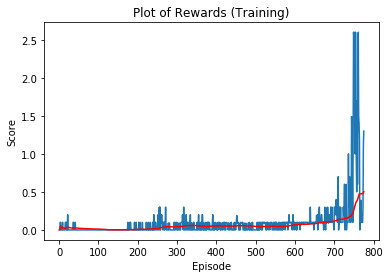

In [13]:
# plot the scores
fig = plt.figure()
plt.title('Plot of Rewards (Training)')
episodes = np.arange(1, len(scores) + 1)
plt.plot(episodes, scores, label = 'Score of DDPG')
plt.plot(episodes, avg_scores, 'r', label = 'Average score')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### 5. Test agents after training

In [14]:
n_episodes = 50
eps = 0.
test_scores = []
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode = False)[brain_name] # reset the environment
    states = env_info.vector_observations              # get the current state
    maddpg.reset()
    scores = np.zeros(hp.num_agents)
    while True:
        actions = maddpg.act(states)
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        next_states = env_info.vector_observations   # get the next state
        rewards = env_info.rewards                   # get the reward
        dones = env_info.local_done                  # see if episode has finished
        maddpg.step(states, actions, rewards, next_states, dones) # learning step
        scores += rewards                                # update the score
        states = next_states                             # roll over the state to next time step
        if np.any(dones): break                                 # exit loop if episode finished
    max_score = np.max(scores)
    test_scores.append(max_score)              # save most recent score
    print('Episode {}\tScore: {:.4f}'.format(i_episode, max_score))

Episode 1	Score: 1.1000
Episode 2	Score: 2.6000
Episode 3	Score: 0.6000
Episode 4	Score: 0.1000
Episode 5	Score: 0.0000
Episode 6	Score: 1.0000
Episode 7	Score: 1.4000
Episode 8	Score: 0.6000
Episode 9	Score: 0.1000
Episode 10	Score: 0.4000
Episode 11	Score: 0.2000
Episode 12	Score: 0.3000
Episode 13	Score: 0.1000
Episode 14	Score: 1.4000
Episode 15	Score: 2.6000
Episode 16	Score: 2.1000
Episode 17	Score: 2.3900
Episode 18	Score: 0.3000
Episode 19	Score: 0.5000
Episode 20	Score: 0.2000
Episode 21	Score: 0.1000
Episode 22	Score: 0.4000
Episode 23	Score: 0.1000
Episode 24	Score: 2.3000
Episode 25	Score: 2.6000
Episode 26	Score: 2.7000
Episode 27	Score: 0.3000
Episode 28	Score: 2.6000
Episode 29	Score: 0.9900
Episode 30	Score: 1.6000
Episode 31	Score: 0.1000
Episode 32	Score: 1.7000
Episode 33	Score: 1.6900
Episode 34	Score: 1.9900
Episode 35	Score: 2.6000
Episode 36	Score: 1.3000
Episode 37	Score: 0.4000
Episode 38	Score: 1.7000
Episode 39	Score: 2.2000
Episode 40	Score: 1.3000
Episode 4

### 6. Plot of Rewards (Testing)

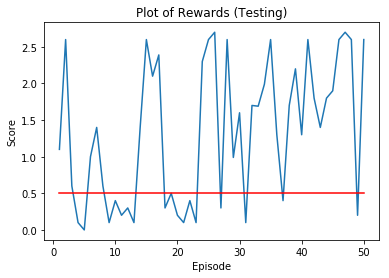

In [15]:
n_scores = len(test_scores)
line = [0.5 for i in range(n_scores)]
episodes = np.arange(1, n_scores + 1)

fig = plt.figure()
plt.title('Plot of Rewards (Testing)')
plt.plot(episodes, test_scores)
plt.plot(episodes, line, 'r')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### 7. Close environment

In [ ]:
env.close()

### Backup project in order to download it with just 1 file

In [21]:
#!zip -r BACKUP_PROJECT3.ZIP *.*

  adding: Tennis.ipynb (deflated 40%)
  adding: checkpoint_actor_0.pth (deflated 7%)
  adding: checkpoint_actor_1.pth (deflated 7%)
  adding: checkpoint_critic_0.pth (deflated 8%)
  adding: checkpoint_critic_1.pth (deflated 8%)
  adding: ddpg.py (deflated 70%)
  adding: maddpg.py (deflated 66%)
  adding: model.py (deflated 76%)
  adding: ounoise.py (deflated 58%)
  adding: replay_buffer.py (deflated 69%)
  adding: unity-environment.log (stored 0%)
